# AD Analysis q-RASAR

In [1]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ===============================
# Fungsi konversi list → ExplicitBitVect aman
# ===============================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits harus ditentukan jika fingerprint kosong")
        fp_list = [0]*n_bits
    if n_bits is None:
        n_bits = len(fp_list)
    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ===============================
# Max Tanimoto similarity function cepat
# ===============================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    max_sims = []
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))
    return np.array(max_sims)

# ===============================
# Read-Across Prediction (kNN similarity weighted)
# ===============================
def read_across_similarity(fp_test_list, fp_train_list, y_train, k=5):

    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bv[0])
    
    ra_pred = []
    ra_sim_mean = []

    for fp_test in fp_test_list:

        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)

        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bv)
        sims = np.array(sims)

        # Ambil k tetangga terdekat
        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        ra_pred.append(pred)
        ra_sim_mean.append(sims[idx].mean())

    return np.array(ra_pred), np.array(ra_sim_mean)

# ===============================
# Leverage physicochemical
# ===============================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples,1)), X_train])
    X_test_aug = np.hstack([np.ones((X_test.shape[0],1)), X_test])
    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3*(n_features+1)/n_samples
    return H_test, h_star, H_test <= h_star

# ===============================
# Input files
# ===============================
input_files = [
    r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx",
    r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Test_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx"
]

# ===============================
# Read Train set
# ===============================
train_df = pd.read_excel(input_files[0])

# Kolom physicochemical
physchem_cols = [col for col in train_df.columns if col not in 
                 ["SMILES","Outcome","Morgan_Descriptors","MACCS_Descriptors",
                  "APF_Descriptors","RDK_Descriptors"]]
physchem_cols = [c for c in physchem_cols if pd.api.types.is_numeric_dtype(train_df[c])]

train_df[physchem_cols] = train_df[physchem_cols].fillna(train_df[physchem_cols].median())

scaler = StandardScaler()
X_train_physchem = scaler.fit_transform(train_df[physchem_cols])

y_train = train_df["Outcome"].values

fp_train_rdkit = train_df["RDK_Descriptors"].tolist()

# ===============================
# Process Train + Test
# ===============================
for file_path in input_files:
    print(f"\nProcessing: {file_path}\n{'-'*50}")
    
    df = pd.read_excel(file_path)

    df[physchem_cols] = df[physchem_cols].fillna(train_df[physchem_cols].median())

    # ============ QSAR AD (Morgan, MACCS, APF, Physchem) ============
    for fp_name in ["Morgan_Descriptors","MACCS_Descriptors","APF_Descriptors"]:
        train_fps = train_df[fp_name].tolist()
        test_fps = df[fp_name].tolist()
        max_sims = max_similarity_to_train_fast(test_fps, train_fps)
        df[f"{fp_name}_IN_AD"] = max_sims >= 0.5

    X_test_physchem = scaler.transform(df[physchem_cols])
    H_test, h_star, physchem_in_ad = leverage_physchem(X_train_physchem, X_test_physchem)
    df["Physchem_IN_AD"] = physchem_in_ad

    df["QSAR_Consensus_IN_AD"] = df[[
        "Morgan_Descriptors_IN_AD",
        "MACCS_Descriptors_IN_AD",
        "APF_Descriptors_IN_AD",
        "Physchem_IN_AD"
    ]].sum(axis=1) >= 2

    # ============ READ-ACROSS AD ============
    fp_test_rdkit = df["RDK_Descriptors"].tolist()

    ra_pred, ra_sim_mean = read_across_similarity(
        fp_test_rdkit,
        fp_train_rdkit,
        y_train,
        k=5
    )

    df["RA_pred"] = ra_pred
    df["RA_mean_similarity"] = ra_sim_mean

    similarity_threshold = np.percentile(ra_sim_mean, 5)
    df["RA_IN_AD"] = df["RA_mean_similarity"] >= similarity_threshold

    # ============ q-RASAR AD ============
    df["qRASAR_IN_AD"] = df["QSAR_Consensus_IN_AD"] & df["RA_IN_AD"]

    # ============ Report ============
    coverage = {
        "QSAR_Consensus_IN_AD_%": df["QSAR_Consensus_IN_AD"].mean()*100,
        "RA_IN_AD_%": df["RA_IN_AD"].mean()*100,
        "qRASAR_IN_AD_%": df["qRASAR_IN_AD"].mean()*100
    }

    print("\nAD Coverage (% compounds inside AD):")
    for k,v in coverage.items():
        print(f"{k}: {v:.2f}%")

    output_name = "AD_QSAR_RA_qRASAR_" + os.path.basename(file_path)
    output_path = os.path.join(os.path.dirname(file_path), output_name)
    df.to_excel(output_path, index=False)
    print(f"Saved Excel: {output_path}")



Processing: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx
--------------------------------------------------

AD Coverage (% compounds inside AD):
QSAR_Consensus_IN_AD_%: 100.00%
RA_IN_AD_%: 94.85%
qRASAR_IN_AD_%: 94.85%
Saved Excel: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\AD_QSAR_RA_qRASAR_Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx

Processing: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Test_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx
--------------------------------------------------

AD Coverage (% compounds inside AD):
QSAR_Consensus_IN_AD_%: 95.62%
RA_IN_AD_%: 94.89%
qRASAR_IN_AD_%: 91.97%
Saved Excel: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\AD_QSAR_RA_qRASAR_Test_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx


# Read Across Only

In [10]:
import os
import pandas as pd
import numpy as np
from rdkit import DataStructs
import ast

# =========================================================
# Convert list → ExplicitBitVect
# =========================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0]*n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# =========================================================
# Read-Across kNN weighted
# =========================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):

    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)

        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]          # k nearest neighbors
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# =========================================================
# Input
# =========================================================
train_path = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx"
test_path  = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Test_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx"

# =========================================================
# Load Train
# =========================================================
train_df = pd.read_excel(train_path)
y_train = train_df["Outcome"].values

descriptor_list = ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors", "RDK_Descriptors"]

# =========================================================
# RA ONLY Pipeline
# =========================================================
for file_path in [train_path, test_path]:

    print(f"\nProcessing RA only: {file_path}\n{'-'*50}")
    df = pd.read_excel(file_path)

    # Loop setiap fingerprint
    for desc in descriptor_list:

        fp_train = train_df[desc].tolist()
        fp_test  = df[desc].tolist()

        ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)

        df[f"RA_pred_{desc}"] = ra_pred
        df[f"RA_meanSim_{desc}"] = ra_sim

        # AD threshold (5th percentile)
        thr = np.percentile(ra_sim, 5)
        df[f"RA_IN_AD_{desc}"] = ra_sim >= thr

    # =====================================================
    # Consensus Read-Across
    # =====================================================
    df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in descriptor_list]].mean(axis=1)
    df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in descriptor_list]].mean(axis=1)

    # AD consensus = majority of descriptor AD
    df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in descriptor_list]].sum(axis=1) >= 2

    # Report
    print("\nAD Coverage:")
    for d in descriptor_list:
        print(f" - {d}: {df[f'RA_IN_AD_{d}'].mean()*100:.2f}%")
    print(f" - CONSENSUS: {df['RA_IN_AD_CONS'].mean()*100:.2f}%")

    # Save
    out_name = "AD_RA_4FP_" + os.path.basename(file_path)
    out_path = os.path.join(os.path.dirname(file_path), out_name)
    df.to_excel(out_path, index=False)
    print(f"Saved: {out_path}")



Processing RA only: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx
--------------------------------------------------

AD Coverage:
 - Morgan_Descriptors: 94.85%
 - MACCS_Descriptors: 94.85%
 - APF_Descriptors: 94.85%
 - RDK_Descriptors: 94.85%
 - CONSENSUS: 97.98%
Saved: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\AD_RA_4FP_Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx

Processing RA only: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Test_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx
--------------------------------------------------

AD Coverage:
 - Morgan_Descriptors: 94.89%
 - MACCS_Descriptors: 94.89%
 - APF_Descriptors: 94.89%
 - RDK_Descriptors: 94.89%
 - CONSENSUS: 98.54%
Saved: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\AD_RA_4FP_Test_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx


# q-RASAR

In [18]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Dermal\Train_set_Dermal_with_fingerprints_RDKit_CDK.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Dermal\Test_set_Dermal_with_fingerprints_RDKit_CDK.xlsx"
    ]


    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Dermal\Train_set_Dermal_with_fingerprints_RDKit_CDK.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Test_set_Dermal_with_fingerprints_RDKit_CDK.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Dermal\Train_set_Dermal_with_fingerprints_RDKit_CDK.xlsx
   Training samples: 611
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_set_Dermal_with_fingerprints_RDKit_CDK.xlsx
   Total samples: 611

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 611/611 (100.00%) IN AD
   MACCS          : 611/611 (100.00%) IN AD
   APF            : 611/611 (100.00%) IN AD
   Physchem       : 590/611 (96.56%) IN AD
   C

In [19]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\Test_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx"
    ]


    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Test_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx
   Training samples: 544
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx
   Total samples: 544

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 544/544 (100.00%) IN AD
   MACCS          : 544/544 (100.00%) IN AD
   APF            : 544/544 (100.00%) IN AD
   Physchem       : 515

In [20]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Oral\Train_set_Oral_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Oral\Test_set_Oral_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]


    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Oral\Train_set_Oral_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Test_set_Oral_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Oral\Train_set_Oral_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 6753
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_set_Oral_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 6753

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 6753/6753 (100.00%) IN AD
   MACCS          : 6753/6753 (100.00%) IN 

In [21]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\AMES\AMES_Train set.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\AMES\AMES_Set1_external_validation.xlsx",
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\AMES\AMES_Set2_external_validation.xlsx"
    ]


    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\AMES\AMES_Train set.xlsx
Test files: 2

################################################################################
PROCESSING DATASET 1/2
Test file: AMES_Set1_external_validation.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\AMES\AMES_Train set.xlsx
   Training samples: 8294
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: AMES_Train set.xlsx
   Total samples: 8294

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 8294/8294 (100.00%) IN AD
   MACCS          : 8294/8294 (100.00%) IN AD
   APF            : 8294/8294 (100.00%) IN AD
   Physchem       : 8007/8294 (96.54%) IN AD
   Consensus      : 8294/8294 (100.00%) IN AD

PERSENTASE QSAR AD
METODE                              IN AD    OUT

In [22]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Carcinogencitiy\Train_set_Carcinogenicity.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Carcinogencitiy\Test_set__Carcinogenicity.xlsx"
    ]


    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Carcinogencitiy\Train_set_Carcinogenicity.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Test_set__Carcinogenicity.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Carcinogencitiy\Train_set_Carcinogenicity.xlsx
   Training samples: 1331
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_set_Carcinogenicity.xlsx
   Total samples: 1331

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 1331/1331 (100.00%) IN AD
   MACCS          : 1331/1331 (100.00%) IN AD
   APF            : 1331/1331 (100.00%) IN AD
   Physchem       : 1282/1331 (96.32%) IN AD
   Consensus      : 1331/1331 (100.00%) IN AD

PERSENTASE QSAR 

In [23]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Cardiotoxicity\CardioTox_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Cardiotoxicity\CardioTox_Test_set 1_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx",
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Cardiotoxicity\CardioTox_Test_set 2_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx",
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Cardiotoxicity\CardioTox_Test_set 3_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]


    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Cardiotoxicity\CardioTox_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 3

################################################################################
PROCESSING DATASET 1/3
Test file: CardioTox_Test_set 1_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Cardiotoxicity\CardioTox_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 12620
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: CardioTox_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 12620

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 12620/12620 (100.00%) IN AD
   MACCS 

In [24]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Development Toxicity\Dev_Train set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Development Toxicity\Dev_Test_set_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]


    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Development Toxicity\Dev_Train set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Dev_Test_set_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Development Toxicity\Dev_Train set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 234
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Dev_Train set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 234

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 234/234 (100.00%) IN AD
   MACCS          : 23

In [25]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\DILI\DILI_train_split.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\DILI\DILI_test_split.xlsx"
    ]


    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\DILI\DILI_train_split.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: DILI_test_split.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\DILI\DILI_train_split.xlsx
   Training samples: 380
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: DILI_train_split.xlsx
   Total samples: 380

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 380/380 (100.00%) IN AD
   MACCS          : 380/380 (100.00%) IN AD
   APF            : 380/380 (100.00%) IN AD
   Physchem       : 358/380 (94.21%) IN AD
   Consensus      : 380/380 (100.00%) IN AD

PERSENTASE QSAR AD
METODE                              IN AD    OUT AD   % IN AD   
---

In [26]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Drug Induced Nephrotoxicity\Train_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Drug Induced Nephrotoxicity\External Validation_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx",
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Drug Induced Nephrotoxicity\Test_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]

    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Drug Induced Nephrotoxicity\Train_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 2

################################################################################
PROCESSING DATASET 1/2
Test file: External Validation_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Drug Induced Nephrotoxicity\Train_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 672
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 672

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 672/672 (100.00%) IN AD
   MACCS          : 67

In [27]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Eye Irritation\Train_set_Eye_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Eye Irritation\Test_set_Eye_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]

    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Eye Irritation\Train_set_Eye_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Test_set_Eye_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Eye Irritation\Train_set_Eye_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 1832
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_set_Eye_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 1832

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 1832/1832 (100.00%) IN AD
   

In [28]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\FDA MDD\Train_set_FDAMMD_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\FDA MDD\Test_set_FDAMMD_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]

    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\FDA MDD\Train_set_FDAMMD_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Test_set_FDAMMD_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\FDA MDD\Train_set_FDAMMD_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 642
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_set_FDAMMD_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 642

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 642/642 (100.00%) IN AD
   MACCS          : 642/642 (100.00%) IN AD
 

In [29]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Hematotoxicity (Manual)\Train_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Hematotoxicity (Manual)\Test_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]

    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Hematotoxicity (Manual)\Train_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Test_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Hematotoxicity (Manual)\Train_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 1905
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_Set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 1905

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 1905/1905 (100.00%) IN AD
   MACCS          : 1905/1905 (100.00%) IN AD

In [30]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Hepatoxicity\HEP_Train_set_train_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Hepatoxicity\Test_set_ValRandom_fingerprints_with_RDKit_CDK.xlsx",
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Hepatoxicity\Ext_Val_ValBLACK_blackNE_.xlsx"
    ]

    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Hepatoxicity\HEP_Train_set_train_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 2

################################################################################
PROCESSING DATASET 1/2
Test file: Test_set_ValRandom_fingerprints_with_RDKit_CDK.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Hepatoxicity\HEP_Train_set_train_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 1087
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: HEP_Train_set_train_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 1087

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 1087/1087 (100.00%) IN AD
   MACCS          : 1087/1087 (100.00%) IN A

In [31]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Mitochondrial Toxicity\Train_ManualSplit_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Mitochondrial Toxicity\Test_ManualSplit_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]

    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Mitochondrial Toxicity\Train_ManualSplit_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Test_ManualSplit_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Mitochondrial Toxicity\Train_ManualSplit_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 2725
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_ManualSplit_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 2725

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 2725/2725 (100.00%) IN AD
   MACC

In [32]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\NeuroToxicity\Train_Set_with_fingerprints_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\NeuroToxicity\Validation_Set_with_fingerprints_with_RDKit_and_CDK_features.xlsx"
    ]

    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\NeuroToxicity\Train_Set_with_fingerprints_with_RDKit_and_CDK_features.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Validation_Set_with_fingerprints_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\NeuroToxicity\Train_Set_with_fingerprints_with_RDKit_and_CDK_features.xlsx
   Training samples: 549
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Train_Set_with_fingerprints_with_RDKit_and_CDK_features.xlsx
   Total samples: 549

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 549/549 (100.00%) IN AD
   MACCS          : 549/549 (100.00%) IN AD
   APF            : 549/549 (100.00%) I

In [34]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Skin Irritation\Skin Irit_train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Skin Irritation\Skin Irit_test_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]

    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Skin Irritation\Skin Irit_train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: Skin Irit_test_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Skin Irritation\Skin Irit_train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 440
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Skin Irit_train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 440

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 440/440 (100.00%) IN AD
   MACCS         

In [35]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Skin Sensinization\SkinSen_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Skin Sensinization\SkinSen_Test_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]
    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Skin Sensinization\SkinSen_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 1

################################################################################
PROCESSING DATASET 1/1
Test file: SkinSen_Test_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Skin Sensinization\SkinSen_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 1028
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: SkinSen_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 1028

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 1028/1028 (100.00%) IN AD
   MACCS       

In [1]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
import ast
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. HELPER: Convert list → RDKit ExplicitBitVect
# ============================================================
def convert_to_bitvect(fp_list, n_bits=None):
    if isinstance(fp_list, str):
        try:
            fp_list = ast.literal_eval(fp_list)
        except:
            fp_list = []
    if fp_list is None or len(fp_list) == 0:
        if n_bits is None:
            raise ValueError("n_bits must be specified for empty fp")
        fp_list = [0] * n_bits

    if n_bits is None:
        n_bits = len(fp_list)

    bv = DataStructs.ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if bit:
            bv.SetBit(i)
    return bv

# ============================================================
# 2. QSAR AD – Maximum Tanimoto Similarity
# ============================================================
def max_similarity_to_train_fast(fp_test_list, fp_train_list):
    """Fast Tanimoto similarity computation."""
    train_bvs = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits_list = len(train_bvs[0])
    max_sims = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits_list)
        sims = DataStructs.BulkTanimotoSimilarity(test_bv, train_bvs)
        max_sims.append(max(sims))

    return np.array(max_sims)

# ============================================================
# 3. QSAR AD – Leverage Physicochemical
# ============================================================
def leverage_physchem(X_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    n_samples, n_features = X_train.shape
    X_train_aug = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    XtX_inv = np.linalg.pinv(X_train_aug.T @ X_train_aug)
    H_test = np.sum((X_test_aug @ XtX_inv) * X_test_aug, axis=1)
    h_star = 3 * (n_features + 1) / n_samples

    return H_test, h_star, H_test <= h_star

# ============================================================
# 4. Read-Across kNN (Weighted)
# ============================================================
def ra_model(fp_test_list, fp_train_list, y_train, k=5):
    train_bv = [convert_to_bitvect(fp) for fp in fp_train_list]
    n_bits = len(train_bv[0])

    preds = []
    sim_means = []

    for fp_test in fp_test_list:
        test_bv = convert_to_bitvect(fp_test, n_bits=n_bits)
        sims = np.array(DataStructs.BulkTanimotoSimilarity(test_bv, train_bv))

        idx = sims.argsort()[-k:]
        weights = sims[idx] / (sims[idx].sum() + 1e-8)

        pred = np.dot(weights, y_train[idx])
        preds.append(pred)
        sim_means.append(sims[idx].mean())

    return np.array(preds), np.array(sim_means)

# ============================================================
# 5. FUNGSI UNTUK MENAMPILKAN PERSENTASE
# ============================================================
def calculate_percentages(df, ad_columns):
    """Menghitung persentase IN AD untuk kolom-kolom yang diberikan"""
    results = {}
    total_samples = len(df)
    
    for col in ad_columns:
        if col in df.columns:
            in_ad = df[col].sum()
            percentage = (in_ad / total_samples) * 100
            results[col] = {
                'IN': int(in_ad),
                'OUT': total_samples - int(in_ad),
                'Percentage_IN': round(percentage, 2)
            }
    
    return results

def print_percentage_summary(title, results):
    """Mencetak ringkasan persentase dengan format yang rapi"""
    print(f"\n{'='*60}")
    print(f"PERSENTASE {title}")
    print(f"{'='*60}")
    print(f"{'METODE':<35} {'IN AD':<8} {'OUT AD':<8} {'% IN AD':<10}")
    print(f"{'-'*60}")
    
    for method, stats in results.items():
        print(f"{method:<35} {stats['IN']:<8} {stats['OUT']:<8} {stats['Percentage_IN']:<8.2f}%")
    
    # Hitung total/rerata jika lebih dari satu metode
    if len(results) > 1:
        avg_percentage = np.mean([stats['Percentage_IN'] for stats in results.values()])
        print(f"{'-'*60}")
        print(f"{'RATA-RATA':<35} {'-':<8} {'-':<8} {avg_percentage:<8.2f}%")

# ============================================================
# 6. PIPELINE TERPADU: QSAR AD + RA AD + q-RASAR
# ============================================================

def run_qrasar_pipeline(train_path, test_path):

    print("\n" + "="*70)
    print("      RUNNING FULL PIPELINE: QSAR → RA → qRASAR")
    print("="*70 + "\n")

    # -----------------------------
    # Load TRAIN
    # -----------------------------
    print(f"📂 Loading training data: {train_path}")
    train_df = pd.read_excel(train_path)
    y_train = train_df["Outcome"].values
    print(f"   Training samples: {len(train_df)}")
    
    fingerprint_cols = [
        "Morgan_Descriptors",
        "MACCS_Descriptors",
        "APF_Descriptors",
        "RDK_Descriptors"
    ]

    # -----------------------------
    # Physchem columns
    # -----------------------------
    physchem_cols = [
        c for c in train_df.columns
        if c not in ["SMILES", "Outcome"] + fingerprint_cols
    ]
    physchem_cols = [
        c for c in physchem_cols
        if pd.api.types.is_numeric_dtype(train_df[c])
    ]
    print(f"   Physicochemical descriptors: {len(physchem_cols)}")
    
    # Fill NA
    train_df[physchem_cols] = train_df[physchem_cols].fillna(
        train_df[physchem_cols].median()
    )

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[physchem_cols])

    # ======================================================
    # PROCESS TRAIN + TEST TOGETHER (2 FILES)
    # ======================================================
    for i, file_path in enumerate([train_path, test_path]):
        
        is_train = (i == 0)
        file_type = "TRAIN" if is_train else "TEST"
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {file_type} FILE: {os.path.basename(file_path)}")
        print(f"{'='*70}")
        
        df = pd.read_excel(file_path)
        print(f"   Total samples: {len(df)}")
        
        # fill NA physchem
        df[physchem_cols] = df[physchem_cols].fillna(
            train_df[physchem_cols].median()
        )

        # ======================================================
        # 5.1 QSAR AD – Fingerprint AD
        # ======================================================
        print("\n📊 1. QSAR AD Analysis:")
        print(f"   {'-'*40}")
        
        qsar_fingerprint_results = {}
        for fp in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors"]:
            train_fps = train_df[fp].tolist()
            test_fps  = df[fp].tolist()

            sims = max_similarity_to_train_fast(test_fps, train_fps)
            df[f"{fp}_IN_AD"] = sims >= 0.5
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"{fp}_IN_AD"].sum()
            qsar_fingerprint_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({qsar_fingerprint_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # Physchem AD
        X_test = scaler.transform(df[physchem_cols])
        H_test, h_star, physchem_pass = leverage_physchem(X_train, X_test)
        df["Physchem_IN_AD"] = physchem_pass
        
        physchem_in = df["Physchem_IN_AD"].sum()
        qsar_fingerprint_results["Physchem"] = {
            'IN': int(physchem_in),
            'OUT': len(df) - int(physchem_in),
            'Percentage_IN': round((physchem_in / len(df)) * 100, 2)
        }
        print(f"   {'Physchem':<15}: {physchem_in}/{len(df)} ({qsar_fingerprint_results['Physchem']['Percentage_IN']:.2f}%) IN AD")

        # QSAR Consensus AD
        qsar_cols = [
            "Morgan_Descriptors_IN_AD",
            "MACCS_Descriptors_IN_AD",
            "APF_Descriptors_IN_AD",
            "Physchem_IN_AD"
        ]
        df["Consensus_IN_AD"] = df[qsar_cols].sum(axis=1) >= 2
        
        consensus_in = df["Consensus_IN_AD"].sum()
        qsar_fingerprint_results["Consensus"] = {
            'IN': int(consensus_in),
            'OUT': len(df) - int(consensus_in),
            'Percentage_IN': round((consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {consensus_in}/{len(df)} ({qsar_fingerprint_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary QSAR
        print_percentage_summary("QSAR AD", qsar_fingerprint_results)

        # ======================================================
        # 5.2 READ ACROSS – AD
        # ======================================================
        print("\n📊 2. Read-Across AD Analysis:")
        print(f"   {'-'*40}")
        
        ra_results = {}
        for fp in fingerprint_cols:
            fp_train = train_df[fp].tolist()
            fp_test  = df[fp].tolist()

            ra_pred, ra_sim = ra_model(fp_test, fp_train, y_train, k=5)
            df[f"RA_pred_{fp}"] = ra_pred
            df[f"RA_meanSim_{fp}"] = ra_sim

            thr = np.percentile(ra_sim, 5)
            df[f"RA_IN_AD_{fp}"] = ra_sim >= thr
            
            # Simpan hasil untuk summary
            in_ad_count = df[f"RA_IN_AD_{fp}"].sum()
            ra_results[fp.replace("_Descriptors", "")] = {
                'IN': int(in_ad_count),
                'OUT': len(df) - int(in_ad_count),
                'Percentage_IN': round((in_ad_count / len(df)) * 100, 2)
            }
            
            print(f"   {fp.replace('_Descriptors', ''):<15}: {in_ad_count}/{len(df)} ({ra_results[fp.replace('_Descriptors', '')]['Percentage_IN']:.2f}%) IN AD")

        # RA Consensus AD
        df["RA_pred_CONS"] = df[[f"RA_pred_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_meanSim_CONS"] = df[[f"RA_meanSim_{d}" for d in fingerprint_cols]].mean(axis=1)
        df["RA_IN_AD_CONS"] = df[[f"RA_IN_AD_{d}" for d in fingerprint_cols]].sum(axis=1) >= 2
        
        ra_consensus_in = df["RA_IN_AD_CONS"].sum()
        ra_results["Consensus"] = {
            'IN': int(ra_consensus_in),
            'OUT': len(df) - int(ra_consensus_in),
            'Percentage_IN': round((ra_consensus_in / len(df)) * 100, 2)
        }
        print(f"   {'Consensus':<15}: {ra_consensus_in}/{len(df)} ({ra_results['Consensus']['Percentage_IN']:.2f}%) IN AD")
        
        # Print summary RA
        print_percentage_summary("READ-ACROSS AD", ra_results)

        # ======================================================
        # 5.3 FINAL q-RASAR AD
        # ======================================================
        print("\n📊 3. q-RASAR AD Analysis:")
        print(f"   {'-'*40}")
        
        df["QRASAR_IN_AD"] = df["Consensus_IN_AD"] & df["RA_IN_AD_CONS"]
        
        qrasar_in = df["QRASAR_IN_AD"].sum()
        qrasar_results = {
            "q-RASAR": {
                'IN': int(qrasar_in),
                'OUT': len(df) - int(qrasar_in),
                'Percentage_IN': round((qrasar_in / len(df)) * 100, 2)
            }
        }
        
        print(f"   Total IN q-RASAR AD: {qrasar_in}/{len(df)} ({qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        print(f"   Total OUT q-RASAR AD: {len(df) - qrasar_in}/{len(df)} ({100 - qrasar_results['q-RASAR']['Percentage_IN']:.2f}%)")
        
        # Print final summary
        print(f"\n{'='*70}")
        print("FINAL SUMMARY - ALL AD METHODS")
        print(f"{'='*70}")
        print(f"{'METODE':<25} {'SAMPLES':<12} {'% IN AD':<10}")
        print(f"{'-'*70}")
        
        # Gabungkan semua hasil
        all_results = {}
        
        # Tambahkan QSAR hasil
        for method, stats in qsar_fingerprint_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"QSAR_{method}"] = stats['Percentage_IN']
        
        all_results["QSAR_Consensus"] = qsar_fingerprint_results["Consensus"]['Percentage_IN']
        
        # Tambahkan RA hasil
        for method, stats in ra_results.items():
            if method != "Consensus":  # Hindari duplikasi
                all_results[f"RA_{method}"] = stats['Percentage_IN']
        
        all_results["RA_Consensus"] = ra_results["Consensus"]['Percentage_IN']
        
        # Tambahkan q-RASAR
        all_results["q-RASAR"] = qrasar_results['q-RASAR']['Percentage_IN']
        
        # Tampilkan semua
        for method, percentage in all_results.items():
            if "Consensus" in method or "q-RASAR" in method:
                print(f"{method:<25} {len(df):<12} {percentage:<8.2f}%")
        
        print(f"{'-'*70}")
        
        # ======================================================
        # OUTPUT: Save Excel
        # ======================================================
        folder = os.path.dirname(file_path)
        base   = os.path.basename(file_path)
        
        # Tambahkan summary ke DataFrame
        summary_df = pd.DataFrame({
            'Total_Samples': [len(df)],
            'QSAR_Morgan_IN': [qsar_fingerprint_results['Morgan']['IN']],
            'QSAR_Morgan_Percent': [qsar_fingerprint_results['Morgan']['Percentage_IN']],
            'QSAR_MACCS_IN': [qsar_fingerprint_results['MACCS']['IN']],
            'QSAR_MACCS_Percent': [qsar_fingerprint_results['MACCS']['Percentage_IN']],
            'QSAR_APF_IN': [qsar_fingerprint_results['APF']['IN']],
            'QSAR_APF_Percent': [qsar_fingerprint_results['APF']['Percentage_IN']],
            'QSAR_Physchem_IN': [qsar_fingerprint_results['Physchem']['IN']],
            'QSAR_Physchem_Percent': [qsar_fingerprint_results['Physchem']['Percentage_IN']],
            'QSAR_Consensus_IN': [qsar_fingerprint_results['Consensus']['IN']],
            'QSAR_Consensus_Percent': [qsar_fingerprint_results['Consensus']['Percentage_IN']],
            'RA_Morgan_IN': [ra_results['Morgan']['IN']],
            'RA_Morgan_Percent': [ra_results['Morgan']['Percentage_IN']],
            'RA_MACCS_IN': [ra_results['MACCS']['IN']],
            'RA_MACCS_Percent': [ra_results['MACCS']['Percentage_IN']],
            'RA_APF_IN': [ra_results['APF']['IN']],
            'RA_APF_Percent': [ra_results['APF']['Percentage_IN']],
            'RA_RDK_IN': [ra_results['RDK']['IN']],
            'RA_RDK_Percent': [ra_results['RDK']['Percentage_IN']],
            'RA_Consensus_IN': [ra_results['Consensus']['IN']],
            'RA_Consensus_Percent': [ra_results['Consensus']['Percentage_IN']],
            'QRASAR_IN': [qrasar_results['q-RASAR']['IN']],
            'QRASAR_Percent': [qrasar_results['q-RASAR']['Percentage_IN']]
        })
        
        # Buat file output yang berbeda untuk summary
        out_file = os.path.join(folder, "QRASAR_AD_" + base)
        summary_file = os.path.join(folder, "SUMMARY_" + base)
        
        # Simpan file utama
        df.to_excel(out_file, index=False)
        print(f"\n✅ Saved detailed results: {out_file}")
        
        # Simpan file summary
        summary_df.to_excel(summary_file, index=False)
        print(f"✅ Saved summary statistics: {summary_file}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📋 Output files created:")
    print("   - QRASAR_AD_[filename].xlsx: Detailed results with all AD columns")
    print("   - SUMMARY_[filename].xlsx: Percentage statistics summary")
    print("\n📊 QRASAR_IN_AD sudah tersedia di kedua file.")


# ============================================================
# >>> RUN PIPELINE (SUPPORT MULTIPLE TEST FILES)
# ============================================================

if __name__ == "__main__":
    train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Respiratory Irritation\Resp_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

    test_files = [
        r"C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Respiratory Irritation\Resp_Test_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx",
        r"C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Respiratory Irritation\Resp_External_validation_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
    ]

    print("🚀 Starting QRASAR AD Pipeline...")
    print(f"Training file: {train_file}")
    print(f"Test files: {len(test_files)}")
    
    # Jalankan pipeline untuk semua test file
    for idx, test_file in enumerate(test_files):
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET {idx+1}/{len(test_files)}")
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"{'#'*80}")
        
        run_qrasar_pipeline(train_file, test_file)

🚀 Starting QRASAR AD Pipeline...
Training file: C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Respiratory Irritation\Resp_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
Test files: 2

################################################################################
PROCESSING DATASET 1/2
Test file: Resp_Test_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
################################################################################

      RUNNING FULL PIPELINE: QSAR → RA → qRASAR

📂 Loading training data: C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Respiratory Irritation\Resp_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Training samples: 1869
   Physicochemical descriptors: 51

PROCESSING TRAIN FILE: Resp_Train_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
   Total samples: 1869

📊 1. QSAR AD Analysis:
   ----------------------------------------
   Morgan         : 1869/1869 (100.00%) IN AD
   MACCS          : 1869/18

Output folder created at:
C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\AD_Visualization_Output



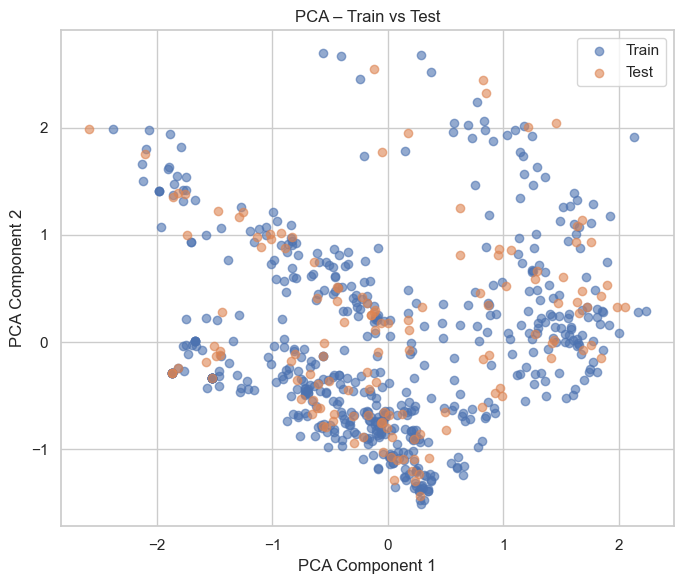

PCA saved → C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\AD_Visualization_Output\PCA_visualization.png


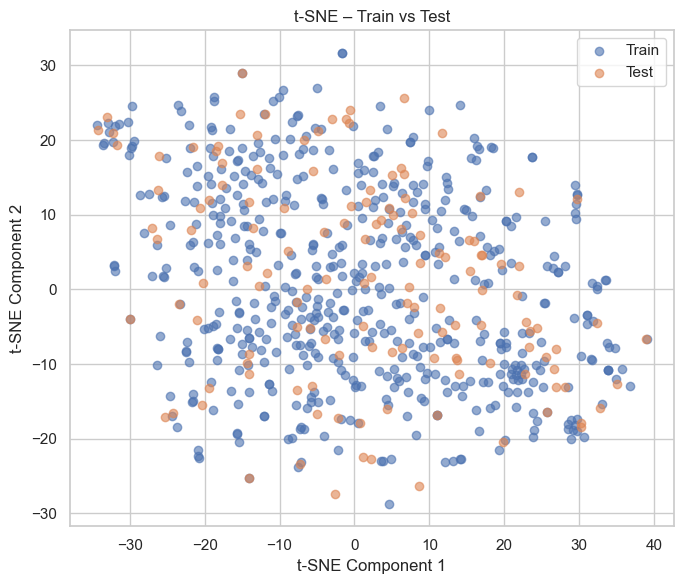

t-SNE saved → C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\AD_Visualization_Output\tSNE_visualization.png

All tasks completed successfully!
All images saved inside:
C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\AD_Visualization_Output


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

# =====================================================================
# 1. INPUT FILES  (URUTANNYA PENTING: [0]=TRAIN, [1]=TEST)
# =====================================================================
input_files = [
    r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Train_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx",
    r"C:\Fauzan\Manuscripts QSAR-RA 2\AD Analysis\Acute Inhalation\QSAR AD\Test_set_Inhalation_with_fingerprints_RDKit_CDK.xlsx"
]

# =====================================================================
# 2. LOAD DATA
# =====================================================================
train_df = pd.read_excel(input_files[0])
test_df = pd.read_excel(input_files[1])

# =====================================================================
# 3. CLEAN COLUMNS → KEEP ONLY REQUIRED ONES
# =====================================================================
allowed_cols = [
    "SMILES",
    "Outcome",
    "Morgan_Descriptors",
    "MACCS_Descriptors",
    "APF_Descriptors",
    "RDK_Descriptors"
]

train_df = train_df[allowed_cols]
test_df = test_df[allowed_cols]

# =====================================================================
# 4. CONVERT DESCRIPTOR STRINGS → NUMPY ARRAYS
# =====================================================================
def convert_descriptor_column(series):
    """
    Convert string of list → numpy array.
    Example: '[0,1,0,...]' → np.array([...])
    """
    return series.apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

for col in ["Morgan_Descriptors", "MACCS_Descriptors", "APF_Descriptors", "RDK_Descriptors"]:
    train_df[col] = convert_descriptor_column(train_df[col])
    test_df[col] = convert_descriptor_column(test_df[col])

# =====================================================================
# 5. CONCAT TRAIN + TEST FOR PCA/t-SNE VISUALIZATION
# =====================================================================
combined = pd.concat([
    train_df.assign(Source="Train"),
    test_df.assign(Source="Test")
])

# Use Morgan (recommended) – or choose any descriptor
descriptor_key = "Morgan_Descriptors"
X = np.vstack(combined[descriptor_key].values)

# =====================================================================
# 6. SET OUTPUT FOLDER (AUTOMATICALLY IN SAME LOCATION AS TRAIN FILE)
# =====================================================================
base_folder = os.path.dirname(input_files[0])
output_folder = os.path.join(base_folder, "AD_Visualization_Output")

os.makedirs(output_folder, exist_ok=True)
print(f"Output folder created at:\n{output_folder}\n")

# =====================================================================
# 7. PCA VISUALIZATION
# =====================================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

combined["PCA1"] = X_pca[:, 0]
combined["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(7, 6))
for src, color in [("Train", "blue"), ("Test", "red")]:
    subset = combined[combined["Source"] == src]
    plt.scatter(subset["PCA1"], subset["PCA2"], label=src, alpha=0.6)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA – Train vs Test")
plt.legend()
plt.tight_layout()

save_path = os.path.join(output_folder, "PCA_visualization.png")
plt.savefig(save_path, dpi=300)
plt.show()
print(f"PCA saved → {save_path}")

# =====================================================================
# 8. t-SNE VISUALIZATION
# =====================================================================
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1500)
X_tsne = tsne.fit_transform(X)

combined["TSNE1"] = X_tsne[:, 0]
combined["TSNE2"] = X_tsne[:, 1]

plt.figure(figsize=(7, 6))
for src, color in [("Train", "blue"), ("Test", "red")]:
    subset = combined[combined["Source"] == src]
    plt.scatter(subset["TSNE1"], subset["TSNE2"], label=src, alpha=0.6)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE – Train vs Test")
plt.legend()
plt.tight_layout()

save_path = os.path.join(output_folder, "tSNE_visualization.png")
plt.savefig(save_path, dpi=300)
plt.show()
print(f"t-SNE saved → {save_path}")

# =====================================================================
# DONE
# =====================================================================
print("\nAll tasks completed successfully!")
print(f"All images saved inside:\n{output_folder}")
